# Cookie Model

Anna Letcher Hartman and Olivia Seitelman

In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

# Question

What is the optimal time to dunk a freshly baked cookie in milk such that it is cool enough to eat as soon as possible?

# Model

We have chosen to model the cooling of the cookie and its dunking in milk using Newton's Law of Cooling. Our model functions in three steps: the cookie cools in the air, it cools in the milk for ten seconds, and then it cools in the air again.

We made an assumption that the cookie soaking in milk is a solid object and does not absorb milk because it is easier to model in that way. However, that is not accurate because milk is absorbed into the cookie and they have much more contact than just at the cookie's surface. The milk would actually cool the cookie much more than in our model.

The update function models the cooling of a cookie when exposed to air. It uses Newton's Law of Cooling to model the interaction between the surface of the cookie and the air calculate the heat it loses to the environment.

In [2]:
def update_func(state, t, system):
    """Update the thermal transfer model.
    
    state: State (temp)
    t: time
    system: System object
    
    returns: State (temp)
    """
    unpack(system)
    
    T = state.T
    # implement Newton's Law of Cooling
    T += -r * (T - T_env) * dt
    
    return State(T=T)

We create a second update function called the dunk function, which simulates dunking the cookie in milk. It also uses Newton's Law of Cooling because the environment just changes to the colder milk.

In [3]:
def dunk_func(state, t, system):
    """Simulates the dunking of cookie into milk.
    
    state: State (temp)
    t: time
    system: System object
    
    returns: State (temp)
    """
    unpack(system)
    
    T = state.T
    T += -r * (T - T_milk) * dt
    
    return State(T=T)

The run simulation function is the same function we have previously used. It creates a TimeFrame and uses a for loop to call the update function with a different value of t at every increment dt.

In [4]:
def run_simulation(system, update_func):
    """Runs a simulation of the system.
    
    Add a TimeFrame to the System: results
    
    system: System object
    update_func: function that updates state
    """
    unpack(system)
    
    frame = TimeFrame(columns=init.index)
    frame.row[t_0] = init
    
    ts = []
    i = t_0
    while i < t_end:
        ts.append(i)
        i += dt

    for t in ts:
        frame.row[t+dt] = update_func(frame.row[t], t, system)
        
    # store the final temperature in T_final
    system.T_final = get_last_value(frame.T)
    
    return frame


Make system creates a system with set values for environmental factors and variable values for the initial temperature, the heat transfer rate `r`, and `t_end`.

In [5]:
def make_system(T_init, r, t_0, t_end, dt):
    """Makes a System object with the given parameters.

    T_init: initial temperature in degrees C
    T_env: air temp
    r: heat transfer rate, in 1/min
    
    returns: System object
    """
    init = State(T=T_init)
    
    # T_final is used to store the final temperature.
    # Before the simulation runs, T_final = T_init
    T_final = T_init

    T_env = 21.1
    T_milk = 5
                
    return System(locals())

In [6]:
system = make_system(104, 0.01, 0, 3.5, .01)

,values
T_milk,5
T_env,21.1
T_final,104
init,T 104 dtype: int64
dt,0.01
t_end,3.5
t_0,0
r,0.01
T_init,104


We want to find the value of `r` that makes the final temperature 64, so we define an "error function" that takes `r` as a parameter and returns the difference between the final temperature and the goal.

In [7]:
def error_func1(r):
    """Runs a simulation and returns the `error`.
    
    r: heat transfer rate, in 1/min
    
    returns: difference between final temp and 70 C
    """
    system = make_system(T_init=104, r=r, t_0=0, t_end=3.5, dt=0.01)
    results = run_simulation(system, update_func)
    return system.T_final - 64

We run the error function with varying values of `r` to find the correct heat transfer rate.

In [8]:
error_func1(r=0.01)

37.14054405843801

In [9]:
error_func1(r=0.1)

15.450005036822617

In [10]:
error_func1(r=0.19)

-0.37463576284170585

In [40]:
error_func1(r=0.1875)

0.0008782446346344841

The best value of r is 0.1875

The return value from `fsolve` is an array with a single element, the estimated value of `r`.

In [41]:
solution = fsolve(error_func1, 0.1875)
r_cookie = solution[0]
r_cookie

0.18750582145536562

If we run the simulation with the estimated value of `r`, the final temperature is 64 C, as expected.

In [42]:
air = make_system(T_init=104, r=r_cookie, t_0=0, t_end=3.5, dt=0.01)
results1 = run_simulation(air, update_func)
air.T_final

64.00000000000026

We will first test each portion of our model individually to be sure that thay are functioning properly. The first run simulation should show the cookie cooling from `T_init = 104` when the cookie comes out of the oven to whatever temperature it hits right before being dunked in milk. The second run simulation should show a sharp drop in temperature as the cookie is being dunked in milk for 10 seconds, and the third will show air cooling again until the cookie reaches its final temperature.

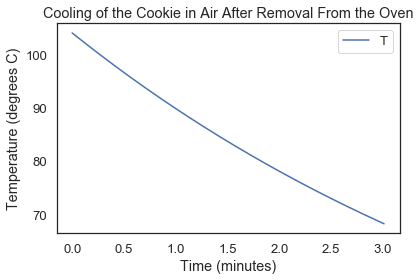

In [46]:
air = make_system(T_init=104, r=r_cookie, t_0=0, t_end=3, dt=0.01)
results1 = run_simulation (air, update_func)

results1.plot()
decorate(title = 'Cooling of the Cookie in Air After Removal From the Oven',
         xlabel='Time (minutes)',
         ylabel = 'Temperature (degrees C)')

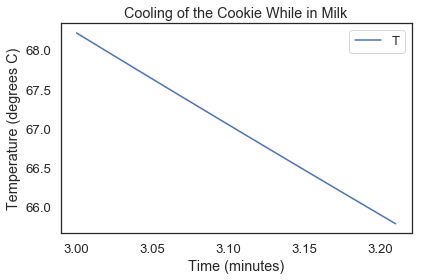

In [47]:
milk = make_system(T_init=air.T_final, r=r_cookie, t_0=air.t_end, t_end=(air.t_end+.2), dt=0.01)
results2 = run_simulation(milk, dunk_func)

results2.plot()
decorate(title = 'Cooling of the Cookie While in Milk',
         xlabel='Time (minutes)',
         ylabel = 'Temperature (degrees C)')

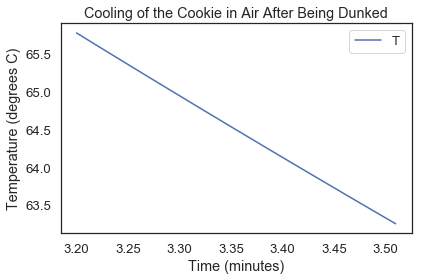

In [48]:
air2 = make_system(T_init=milk.T_final, r=r_cookie, t_0=milk.t_end, t_end=3.5, dt=0.01)
results = run_simulation (air2, update_func)

results.plot()
decorate(title = 'Cooling of the Cookie in Air After Being Dunked',
         xlabel='Time (minutes)',
         ylabel = 'Temperature (degrees C)')

Now that we have confirmed that all parts of the simulation are working individually, we can combine all three smaller simulations into one large one.

In [49]:
def run_world(T_init, r, t_0, t_end, dt, dt2, dt3):
    air = make_system(T_init=T_init, r=r_cookie, t_0=t_0, t_end=t_end, dt=dt)
    results1 = run_simulation(air, update_func)
    
    milk = make_system(T_init=air.T_final, r=r_cookie, t_0=air.t_end+0.01, t_end=(air.t_end+.2), dt=dt2)
    results2 = run_simulation(milk, dunk_func)
    
    air2 = make_system(T_init=milk.T_final, r=r_cookie, t_0=milk.t_end+.01, t_end=3.5, dt=dt3)
    results3 = run_simulation (air2, update_func)

    frames = [results1, results2, results3]
    results = pd.concat(frames)
    
    return results
    

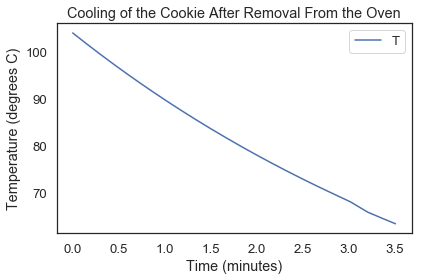

In [51]:
results = run_world (104, r_cookie, 0, 3, 0.01, 0.01, 0.01)
results.plot()
decorate(title = 'Cooling of the Cookie After Removal From the Oven',
         xlabel='Time (minutes)',
         ylabel = 'Temperature (degrees C)')

The plot of the model shows a slight dip in temperature around 3 minutes that represents dunking in milk.

In order to determine the optimal time for dunking, we will sweep time values for the time that the cookie is dunked in milk. Whichever dunk time produces the coldest cookie temperature after a set amount of time will then be plotted on its own. We can use those results to find the exact time when the cookie reaches the optimal temperature.

# Results

In [52]:
def timeSweep(timeArray, r_cookie):
    Tfinal = SweepSeries()
    for time in timeArray:
        results = run_world (105, r_cookie, 0, time, 0.01, 0.01, 0.01)
        Tfinal[time] = get_last_value(results)
        
    return Tfinal

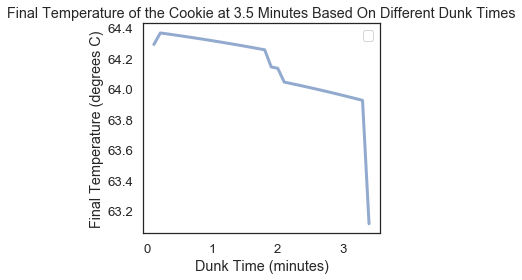

In [59]:
timeArray = linrange(.1,3.5,.1)
Tfinal = timeSweep(timeArray, r_cookie)
plot(Tfinal)
decorate(title = 'Final Temperature of the Cookie at 3.5 Minutes Based On Different Dunk Times',
         xlabel='Dunk Time (minutes)',
         ylabel = 'Final Temperature (degrees C)')

The optimal value of `t` for the dunk time is 3.4 minutes. If we run a simulation with this value of `t`, we can find the time at which the temperature of the cookie reaches 64 degrees, which is the soonest time it can be eaten.

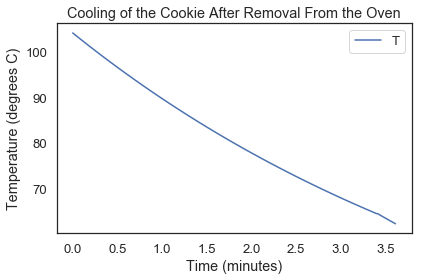

In [56]:
results = run_world (104, r_cookie, 0, 3.4, 0.1, 0.01, 0.1)

results.plot()
decorate(title = 'Cooling of the Cookie After Removal From the Oven',
         xlabel='Time (minutes)',
         ylabel = 'Temperature (degrees C)')

The soonest the cookie can be eaten is 3.48 minutes after it is taken out of the oven if it is dunked at 3.4 minutes.

# Interpretation

Our model was fairly accurate, although a major assumption we made was regarding the cooling of the cookie in milk. The model looked at the cookie as a solid object when it is actually very porous and can absorb milk. Therefore, when we actually dunk the cookie in milk it cools far more than our model predicts. This assumption only slightly impacts our final result. The timing if the dunk remains the same and the cookie just cools more quickly when it is dunked, so the time at which it can be eaten is much sooner after the dunk than we predict. In testing our model we found the dunk time to be accurate but we were able to eat the cookie right after we finished dunking. 

We used iteration in deciding how to structure our model. We went through several different phases of update functions until we settled on having two different update functions and calling the same `run_simulation` 3 times. We also changed it to not have `linrange` as it was not cooperating and despite a lot of debugging we could not identify the exact problem. We modified our `run_world` function in stages and continued to change it and simplify our code. 

# Abstract

Your question.
The answer to your question in 1-2 sentences.
1-2 key, well-labeled figures that show how your model answers your question.
1-2 sentences summarizing your key interpretations.

Question: What is the optimal time to dunk a freshly baked cookie in milk such that it is cool enough to eat as soon as possible?

The best time to dunk the cookie in milk is 3.4 minutes after removing it from the oven, and it will be ready to eat at 3.48 minutes.

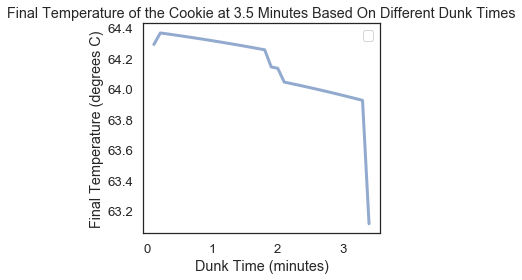

In [60]:
plot(Tfinal)
decorate(title = 'Final Temperature of the Cookie at 3.5 Minutes Based On Different Dunk Times',
         xlabel='Dunk Time (minutes)',
         ylabel = 'Final Temperature (degrees C)')

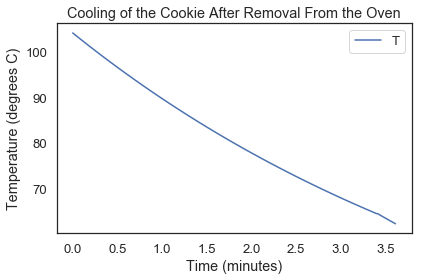

In [61]:
results.plot()
decorate(title = 'Cooling of the Cookie After Removal From the Oven',
         xlabel='Time (minutes)',
         ylabel = 'Temperature (degrees C)')

It is best to dunk the cookie later on after taking it out of the oven.